In [1]:
# ====================================================================
# Author: Rohit Gupta 
# Contact : Email : rohit.gupta.delhi1995@gmail.com  
# PGIMER Project Scientist 1 : Assignment: 
# ====================================================================
# Import all neccesary libraries for model, training, testing, etc.

#directory manipulation: 
import os

# deep learning associated libraries: 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# determine results of training,testing:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# matplotlib, seaborn visualization libraries: 
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()
#os.chdir('/Users/rohitgupta/Downloads/pgimer_assignment/')

'/Users/rohitgupta/Documents/ml_projects'

In [ ]:
# Post the analysis, and retrospection, here are the answers for the questions asked in the assignment.pdf: 

# a. Three Appropriate Metrics and Justifications:
# The evaluation metrics I used were : Precision, Recall, F1 score, AUC-ROC (curve). 
# Each of these metrics were used for the following primary reason: 

# Precision and Recall: Crucial for medical diagnoses, high recall ensures pneumonia cases are not ignored, 
# white precision minimizes false alarms e.g Normal cases being treated as Pneumonia inflicted). 
# F1-Score: Ensures there is a balance between precision and recall values, since both the false positive and 
# false negatives have clinical consequences and economic repercussions.   
# AUC-ROC: It provides a visual depiction as well as provides a quantitative assessment for 
# the model's ability to distinguish between normal and pneumonia cases across different threshold values.
                                                                                     
# b. Class Imbalance Detection and Mitigation:
# Class imbalance detected post running the model on the test dataset and then seeing the model performance 
# evaluation metrics. [388 normal vs 3,494 pneumonia cases]. Furthermore 0 false negatives showing up repeatedly, 
# followed by 1.00 precision for Normal cases. Mitigation strategies applied: Utilized weighted loss function, 
# weighted random sampler, enhanced data augmentation technique (used geometric transformations). 
                                                                                     
# c. Overfitting Prevention Measures:
# I applied data augmentation techniques, and utilized transforms such as RandomResizedCrop, RandomHorizontalFlip, 
# RandomRotation to training data. Furthermore, I also applied regularization techniques such as L2 Weight Decay, 
# Early stopping (with patience = 3, triggered at the epoch run at 4, to prevent overtraining of the ResNet50 model). 
# Fine tuned final classification layer to leverage learned features. However, more improvement with this 
# respect could be done, such as more layers could be unfrozen and utilized. However due to paucity of time, 
# restricted myself to this. 

# Question : A short note on the hyperparameters used: 

# I implemented and optimized different hyperparameters, especially post realizing the class imbalance issue 
# that manifested during the initial training, implementation of the ResNet 50 model. First started with a 
# conservative learning rate of 1e^(-4); batch size of 32 and Adam optimizer with L2 regularization 
# (using a e^(-5) weight decay). 
# Post identification of the class imbalance, and to remedy the overfitting of the model, 
# decided to further adjust the training related hyper-parameters by setting a maximum of 20 epochs, 
# but with early stopping with patience = 3, which halted training at epoch 4 itself, to prevent 
# overfitting (meaning, to prevent the model learning/memorizing the training data itself too well). 
# Finally, addressed the class imbalance again by adjusting CrossEntropyLoss with class weights as 
# [1.7,1.0] and WeightedRandomSampler. Furthermore, did a couple of more adjustments with 
# the hyperparameters as I continued to refine the model to improve performance - especially with 
# class imbalance plaguing it. 


In [3]:
import matplotlib.pyplot as plt
import os

# Create a directory to store the images
output_dir = 'output_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Your code to generate plots goes here
# For example:
for i in range(5):
    plt.figure()
    plt.plot([1, 2, 3, 4], [i, i**2, i**3, i**4])
    plt.title(f'Plot {i+1}')
    
    # Save the figure
    filename = f'plot_{i+1}.png'
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()  # Close the figure to free up memory

print(f"All images have been saved to the '{output_dir}' directory.")

All images have been saved to the 'output_images' directory.


In [4]:
# Evaluation Strategy: 
# Post the analysis the answers for the questions (in the assignment included here): 

# a. Choose 3-appropriate metrics and justify your choices.
# b. Discuss how you detect and mitigate class imbalance in the training set.
# c. Describe measures taken to prevent over-fitting (e.g., data augmentation,
# regularization).

# answer a: 

# answer b: 

# answer c: 

In [5]:
# test if the libraries are working or not: 

import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.2.2
Torchvision version: 0.17.2
CUDA available: False


In [6]:
# running on mac m1 silicon, therefore required to test: 

import torch
if torch.backends.mps.is_available():
    print("MPS is available!")
else:
    print("MPS not available.")

MPS is available!


In [7]:
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)

In [8]:
# path definition: 
os.getcwd()
os.chdir('/Users/rohitgupta/Downloads/pgimer_assignment/')

In [9]:
os.listdir()

['.DS_Store',
 'requirements.txt',
 'enviornment.yml',
 'notebook_images',
 'pneumoniamnist.npz',
 'Assignment.pdf']

In [10]:
# loading the data and checking it: 
from numpy import load

dataset = load('pneumoniamnist.npz')
lst = dataset.files

#for item in lst:
 #   print(item)
 #  print(data[item])

In [11]:
import numpy as np
data = np.load("pneumoniamnist.npz")

print("Keys:", list(data.keys()))
print("Train images shape:", data['train_images'].shape)
print("Can access index 2?", data['train_images'][2].shape)

Keys: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Train images shape: (3882, 28, 28)
Can access index 2? (28, 28)


In [12]:
# Data Preparation so that it can be fed into the model (in this case the ResNet-50)
# First step is to define the transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # ResNet model expects 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Load dataset from folders
#dataset = datasets.ImageFolder(root="./data/train", transform=transform)

In [13]:
# Split into train and validation using the 80,20 rule; 
# 80% of data for training, rest of the 20% for testing: 

from torch.utils.data import Dataset
from PIL import Image

class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.squeeze()  #remove any extra dimensions that may have been there
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image and label
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image for transforms 
        image = Image.fromarray(image, mode='L')  # Grayscale
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        # we must ensure the image tensor is float32 for MPS compatibility
        image = image.float()
        
        return image, torch.tensor(label, dtype=torch.long)
    
    

# load the data
data = np.load("pneumoniamnist.npz")

# Create datasets using the existing splits from the file
train_dataset = PneumoniaDataset(
    data['train_images'], 
    data['train_labels'], 
    transform=transform
)

val_dataset = PneumoniaDataset(
    data['val_images'], 
    data['val_labels'], 
    transform=transform
)

test_dataset = PneumoniaDataset(
    data['test_images'],
    data['test_labels'],
    transform=transform
)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Test that it works
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# Test loading one batch
try:
    batch = next(iter(train_loader))
    print(f"Batch test successful: {batch[0].shape}, {batch[1].shape}")
except Exception as e:
    print(f"Error: {e}")

Train dataset: 3882 samples
Val dataset: 524 samples
Test dataset: 624 samples
Batch test successful: torch.Size([32, 3, 224, 224]), torch.Size([32])


In [14]:
print(data['train_images'].shape)
print(data['test_images'].shape)
print(data['val_images'].shape)

(3882, 28, 28)
(624, 28, 28)
(524, 28, 28)


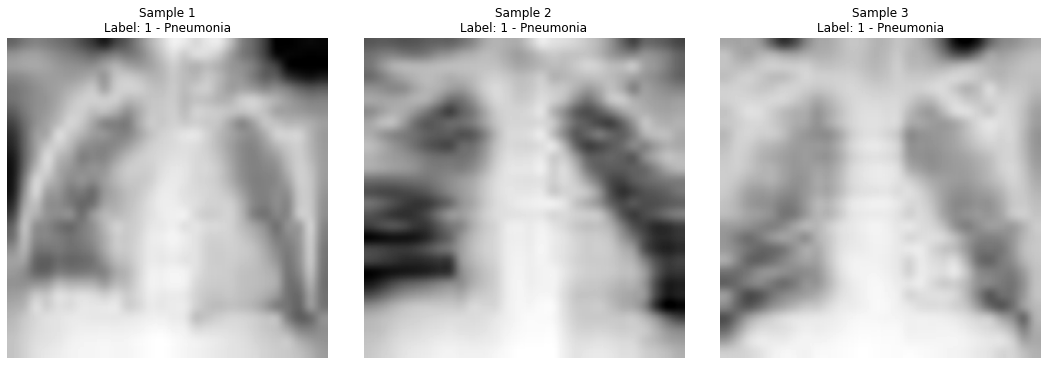

In [15]:
# check how the images look: 

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img = data['train_images'][i]  # shape: (28, 28)
    label = data['train_labels'][i][0]

    # Normalize to 0–255, clip to prevent overflow
    img_scaled = (img - img.min()) / (img.max() - img.min())  # scale 0–1
    img_uint8 = (img_scaled * 255).astype(np.uint8)

    # Convert to PIL, resize with smooth interpolation
    img_pil = Image.fromarray(img_uint8)
    img_resized = img_pil.resize((224, 224), resample=Image.BICUBIC)
    img_np = np.array(img_resized)

    # Display
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f"Sample {i+1}\nLabel: {label} - {'Pneumonia' if label == 1 else 'Normal'}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# setting up the model, using pretrained resnet50 for the assigned task: 
# model name is 'model_res'
model_res = models.resnet50(pretrained=True)

/opt/miniconda3/envs/jupyter/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Replace the final layer
num_ftrs = model_res.fc.in_features

model_res.fc = nn.Linear(num_ftrs, 2).to(device) 

model_res = model_res.to(device) 

#  for verification
print(f"Model device: {next(model_res.parameters()).device}")
print(f"Conv1 weight device: {model_res.conv1.weight.device}")

Model device: mps:0
Conv1 weight device: mps:0


In [18]:
# print model details : helps understand the assigned weights, hyperparameters [useful later for hyperparameter tuning, optimization]
# print(model_res)

In [19]:
# Establishing Loss, Optimzer, Scheduler:
criterion = nn.CrossEntropyLoss() 
# Ensure the optimizer is created AFTER the model is fully moved
optimizer = optim.Adam(model_res.parameters(), lr=1e-4) 

In [20]:
# Training the model: 
# creating the function:  

# train function : 
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model_res.train()
        total_loss = 0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model_res(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        # Change .double() to .float() for MPS compatibility
        acc = correct.float() / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Accuracy={acc:.4f}")
        validate(model, val_loader)


# validation function: 
def validate(model, val_loader):
    model_res.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_res(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data) 
    # Change .double() to .float() for MPS compatibility
    acc = correct.float() / len(val_loader.dataset)        
    #acc = correct.double() / len(val_loader.dataset)
    print(f"Validation Accuracy={acc:.4f}")

In [21]:
# run the training model: 
# we are calling the function above 
# epochs = 10 for the time being, can be changed as well

train(model_res, train_loader, val_loader, criterion, optimizer, epochs=10) 

Epoch 1: Train Loss=15.2182, Accuracy=0.9565
Validation Accuracy=0.9561
Epoch 2: Train Loss=5.9785, Accuracy=0.9815
Validation Accuracy=0.9618
Epoch 3: Train Loss=4.6641, Accuracy=0.9861
Validation Accuracy=0.9599
Epoch 4: Train Loss=1.9434, Accuracy=0.9946
Validation Accuracy=0.9542
Epoch 5: Train Loss=2.0726, Accuracy=0.9954
Validation Accuracy=0.9618
Epoch 6: Train Loss=0.9702, Accuracy=0.9972
Validation Accuracy=0.9427
Epoch 7: Train Loss=0.6306, Accuracy=0.9982
Validation Accuracy=0.9676
Epoch 8: Train Loss=1.8327, Accuracy=0.9951
Validation Accuracy=0.9695
Epoch 9: Train Loss=2.4910, Accuracy=0.9928
Validation Accuracy=0.9427
Epoch 10: Train Loss=1.0815, Accuracy=0.9969
Validation Accuracy=0.9504


In [22]:
validate(model_res,val_loader)

Validation Accuracy=0.9504


In [24]:
# Now finally check how the model fares with respect to test dataset: 
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model_res.eval() 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_res(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# display the classification report lastly: 
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

              precision    recall  f1-score   support

      NORMAL       0.95      0.78      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



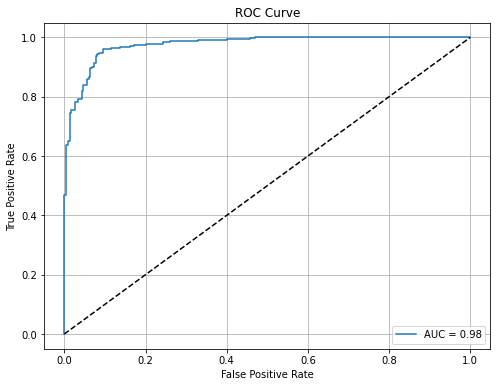

In [25]:
# visualizing the results, by using AUC-ROC Curve [Area Under the Curve - Reciever Operating Characteristics]

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get softmax scores for class 1 (Pneumonia)
model_res.eval()
probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_res(inputs)
        probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(true_labels, probs)
auc = roc_auc_score(true_labels, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

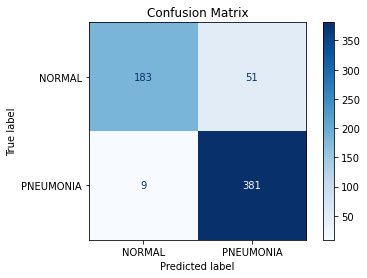

In [26]:
# Plotting a confusion matrix, to understand true positives, false positives, true negatives, false negatives : 
# [correct diagnosis, pneumonia does not exist - but diagnosed, correct diagnosis - with absence of it, pneumonia does not exist - and not diagnosed]
# Interpretation of the confusion matrix : 

# Plotting a confusion matrix to analyze:
# True Positives (TP): Pneumonia exists - and correctly diagnosed
# False Positives (FP): Pneumonia exists - wrongly diagnosed 
# True Negatives (TN): Normal case - correctly diagnosed
# False Negatives (FN): Pneumonia exists - but not diagnosed (strong error)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# use y_true, y_pred

cm = confusion_matrix(y_true, y_pred)

# display labels on the heatmap 
class_names = ["NORMAL", "PNEUMONIA"]

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [27]:
# Interesting observation : False Negative = 0, suggestive of an underlying issue 
# Let us check for 'class imbalance'
# class imbalance (issues)
# how to avoid overfitting errors


labels = data['train_labels']
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Result : Normal(0) : 388, Pneumonia(1)

Class distribution: {0: 388, 1: 3494}


In [28]:
# Initiate remedial steps: 

class_weights = torch.tensor([1.7, 1.0]).to(device)  # Tune based on step above
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [29]:
# Utilize weighted sampler instead of using train_loader: 

from torch.utils.data import WeightedRandomSampler

targets = train_dataset.labels
class_sample_count = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
weights = 1. / class_sample_count
samples_weight = np.array([weights[t] for t in targets])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0)

In [30]:
# Redefine augumented transform : 

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = PneumoniaDataset(
    data['train_images'],
    data['train_labels'],
    transform=train_transform
)

# not doing this for the validation and test datasets

In [31]:
# update optimizer with added regularization: 
optimizer = optim.Adam(model_res.parameters(), lr=1e-4, weight_decay=1e-5)

In [32]:
# Re-train the model and re-evaluate to check the model performance:
train(model_res, train_loader, val_loader, criterion, optimizer, epochs=10)

Epoch 1: Train Loss=3.8799, Accuracy=0.9902
Validation Accuracy=0.9637
Epoch 2: Train Loss=2.2026, Accuracy=0.9941
Validation Accuracy=0.9809
Epoch 3: Train Loss=0.3695, Accuracy=0.9992
Validation Accuracy=0.9733
Epoch 4: Train Loss=0.1312, Accuracy=0.9997
Validation Accuracy=0.9599
Epoch 5: Train Loss=0.0288, Accuracy=1.0000
Validation Accuracy=0.9733
Epoch 6: Train Loss=0.1623, Accuracy=0.9997
Validation Accuracy=0.9542
Epoch 7: Train Loss=4.3638, Accuracy=0.9892
Validation Accuracy=0.9752
Epoch 8: Train Loss=1.1179, Accuracy=0.9967
Validation Accuracy=0.9714
Epoch 9: Train Loss=1.0280, Accuracy=0.9977
Validation Accuracy=0.9733
Epoch 10: Train Loss=1.0894, Accuracy=0.9972
Validation Accuracy=0.9504


In [33]:
# model validation: 
validate(model_res, val_loader)

Validation Accuracy=0.9504


In [34]:
# now on test dataaset: 
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model_res.eval() 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_res(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# display the classification report lastly: 
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

              precision    recall  f1-score   support

      NORMAL       0.96      0.61      0.74       234
   PNEUMONIA       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624



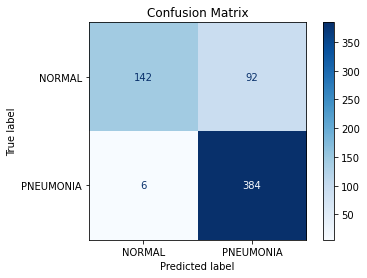

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# use y_true, y_pred

cm = confusion_matrix(y_true, y_pred)

# display labels on the heatmap 
class_names = ["NORMAL", "PNEUMONIA"]

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

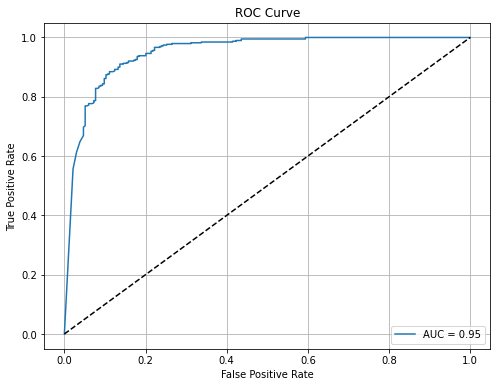

In [36]:
# visualizing the results, by using AUC-ROC Curve [Area Under the Curve - Reciever Operating Characteristics]

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get softmax scores for class 1 (Pneumonia)
model_res.eval()
probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_res(inputs)
        probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(true_labels, probs)
auc = roc_auc_score(true_labels, probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [37]:
# class imbalance still persisting above: 
# False positives (1st quadrant) and False Negatives(third quadrant) high and low respectively.

# the training is still yielding higher on average accuracy, despite the added measures to curtail the overfitting pheonomenon
# we will now add more stronger data augmentation and early stopping

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Zoom in/out
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [38]:
train_dataset = PneumoniaDataset(
    data['train_images'],
    data['train_labels'],
    transform=train_transform
)

# keeping validation and test data set same

In [39]:
# define early stopping : 
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

In [40]:
# Modify training loop to incorporate the early stopping mechanism: 

def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    early_stopping = EarlyStopping(patience=3)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

        train_acc = correct.float() / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Accuracy={train_acc:.4f}")

        val_acc = validate(model, val_loader)

        early_stopping(val_acc)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

In [41]:
# updating the validation function to include the accuracy: 

def validate(model, val_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    acc = correct.float() / len(val_loader.dataset)
    print(f"Validation Accuracy={acc:.4f}")
    return acc 

In [42]:
# run the training: 
train(model_res, train_loader, val_loader, criterion, optimizer, epochs=20) 

Epoch 1: Train Loss=0.8506, Accuracy=0.9974
Validation Accuracy=0.9695
Epoch 2: Train Loss=0.0747, Accuracy=1.0000
Validation Accuracy=0.9656
Epoch 3: Train Loss=0.0231, Accuracy=1.0000
Validation Accuracy=0.9695
Epoch 4: Train Loss=0.0147, Accuracy=1.0000
Validation Accuracy=0.9656
Early stopping triggered.


In [43]:
# model validation: 
validate(model_res, val_loader)

Validation Accuracy=0.9656


tensor(0.9656, device='mps:0')

In [44]:
# model testing (run on test data finally): 
# now on test dataaset: 
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model_res.eval() 
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_res(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# display the classification report lastly: 
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

              precision    recall  f1-score   support

      NORMAL       0.99      0.52      0.68       234
   PNEUMONIA       0.77      1.00      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.86      0.82      0.80       624



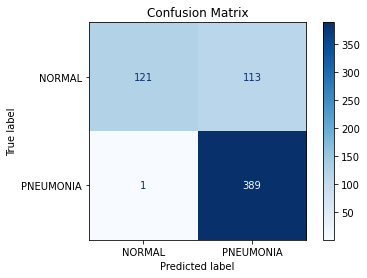

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# use y_true, y_pred

cm = confusion_matrix(y_true, y_pred)

# display labels on the heatmap 
class_names = ["NORMAL", "PNEUMONIA"]

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

/opt/miniconda3/envs/jupyter/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


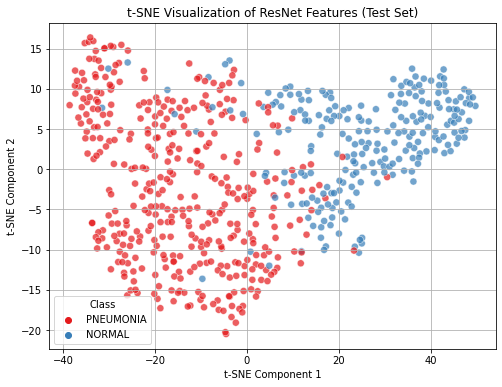

In [46]:
#tSNE visualizationa: 

# Load the required libraries: 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

# Step 1: Extract deep features from the test set using ResNet (remove final layer)
features = []
labels_list = []

# Remove final classification layer
feature_extractor = torch.nn.Sequential(*list(model_res.children())[:-1])
feature_extractor.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = feature_extractor(inputs)  # e.g., [B, 2048, 1, 1] for ResNet-50
        outputs = outputs.view(outputs.size(0), -1)  # Flatten to [B, D]
        features.append(outputs.cpu())
        labels_list.extend(labels.cpu().numpy())

# Stack all features into a numpy array
features_np = torch.cat(features, dim=0).numpy()

# Standardize before t-SNE
features_np = StandardScaler().fit_transform(features_np)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Create a DataFrame and plot
df = pd.DataFrame()
df['x'] = features_2d[:, 0]
df['y'] = features_2d[:, 1]
df['label'] = ['NORMAL' if l == 0 else 'PNEUMONIA' for l in labels_list]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='Set1', alpha=0.7, s=50)
plt.title("t-SNE Visualization of ResNet Features (Test Set)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.legend(title="Class", loc="best")
plt.show()


/opt/miniconda3/envs/jupyter/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


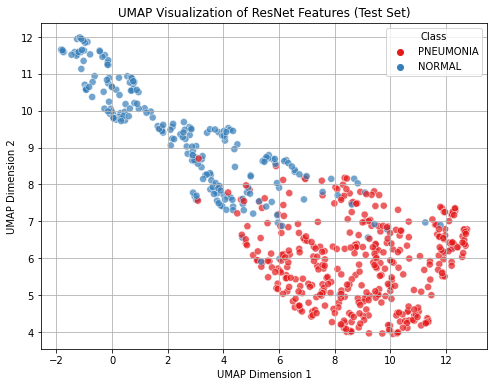

In [47]:
# Import libraries
import umap
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Extract features (same as for t-SNE)
features = []
labels_list = []

feature_extractor = torch.nn.Sequential(*list(model_res.children())[:-1])
feature_extractor.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = feature_extractor(inputs)
        outputs = outputs.view(outputs.size(0), -1)  # flatten to [B, D]
        features.append(outputs.cpu())
        labels_list.extend(labels.cpu().numpy())

features_np = torch.cat(features, dim=0).numpy()

# Standardize 
features_np = StandardScaler().fit_transform(features_np)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_2d = umap_model.fit_transform(features_np)

# Plot UMAP
df_umap = pd.DataFrame()
df_umap['x'] = umap_2d[:, 0]
df_umap['y'] = umap_2d[:, 1]
df_umap['label'] = ['NORMAL' if l == 0 else 'PNEUMONIA' for l in labels_list]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_umap, x='x', y='y', hue='label', palette='Set1', alpha=0.7, s=50)
plt.title("UMAP Visualization of ResNet Features (Test Set)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.legend(title="Class", loc="best")
plt.show()